# Financial Data and Preprocessing 

## Getting data from Yahoo Finance

1. Import the libraries:

In [1]:
# pip install yfinance
# pip install matplotlib

In [2]:
import pandas as pd 
import yfinance as yf
import quandl
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
# import statsmodels.formula.api as smf


2. Download the data:

In [3]:
df_yahoo = yf.download('AAPL', 
                      start='2000-01-01', 
                      end='2022-12-27',
                      progress=False)

3. Inspect the data:

In [4]:
print(f'Downloaded {df_yahoo.shape[0]} rows of data.')

df_yahoo.head()

Downloaded 5783 rows of data.


Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2000-01-03  0.936384  1.004464  0.907924  0.999442   0.851942  535796800
2000-01-04  0.966518  0.987723  0.903460  0.915179   0.780115  512377600
2000-01-05  0.926339  0.987165  0.919643  0.928571   0.791530  778321600
2000-01-06  0.947545  0.955357  0.848214  0.848214   0.723033  767972800
2000-01-07  0.861607  0.901786  0.852679  0.888393   0.757282  460734400

## Getting data from Quandl 

1. Import the libraries:

In [5]:
# pip install Quandl

2. Authenticate using the personal API key:

In [6]:
#QUANDL_KEY = '{key}' # replace {key} with your own API key
QUANDL_KEY = '15L4ky9aN_bF_6uss8CA'
quandl.ApiConfig.api_key = QUANDL_KEY

3. Download the data:

In [7]:
df_quandl = quandl.get(dataset='WIKI/AAPL',
                      start_date='2000-01-01', 
                      end_date='2022-12-27')

4. Inspect the data:

In [8]:
print(f'Downloaded {df_quandl.shape[0]} rows of data.')

df_quandl.head()

Downloaded 4585 rows of data.


Open    High     Low   Close     Volume  Ex-Dividend  \
Date                                                                 
2000-01-03  104.87  112.50  101.69  111.94  4783900.0          0.0   
2000-01-04  108.25  110.62  101.19  102.50  4574800.0          0.0   
2000-01-05  103.75  110.56  103.00  104.00  6949300.0          0.0   
2000-01-06  106.12  107.00   95.00   95.00  6856900.0          0.0   
2000-01-07   96.50  101.00   95.50   99.50  4113700.0          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj. Low  Adj. Close  \
Date                                                                  
2000-01-03          1.0   3.369314   3.614454  3.267146    3.596463   
2000-01-04          1.0   3.477908   3.554053  3.251081    3.293170   
2000-01-05          1.0   3.333330   3.552125  3.309234    3.341362   
2000-01-06          1.0   3.409475   3.437748  3.052206    3.052206   
2000-01-07          1.0   3.100399   3.244977  3.068270    3.196784   

            Adj. Volume  
Date                     
2000-01-03  133949200.0  
2000-01-04  128094400.0  
2000-01-05  194580400.0  
2000-01-06  191993200.0  
2000-01-07  115183600.0

## Converting prices to returns

### How to do it...

1. Import the libraries:

2. Download the data and keep the adjusted close prices only:

In [9]:
df = yf.download('AAPL', 
                start='2000-01-01', 
                end='2022-12-27',
                progress=False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

3. Convert adjusted close prices to simple and log returns:

In [10]:
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

4. Inspect the output:

In [11]:
df.head()

adj_close  simple_rtn   log_rtn
Date                                       
2000-01-03   0.851942         NaN       NaN
2000-01-04   0.780115   -0.084310 -0.088077
2000-01-05   0.791530    0.014633  0.014527
2000-01-06   0.723033   -0.086538 -0.090514
2000-01-07   0.757282    0.047369  0.046281

### There's more

1. Import libraries and authenticate:

In [12]:
QUANDL_KEY = '15L4ky9aN_bF_6uss8CA' # replace your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

2. Create a DataFrame with all possible dates and left join the prices on it:

In [13]:
df_all_dates = pd.DataFrame(index=pd.date_range(start='1999-12-31', 
                                               end='2022-12-27'))
df = df_all_dates.join(df[['adj_close']], how='left') \
.fillna(method='ffill') \
.asfreq('M')

3. Download inflation data from Quandl:

In [14]:
df_cpi = quandl.get(dataset='RATEINF/CPI_USA', 
                   start_date='1999-12-01', 
                   end_date='2022-12-27')
df_cpi.rename(columns={'Value':'cpi'}, inplace=True)

4. Merge inflation data to prices:

In [15]:
df_merged = df.join(df_cpi, how='left')

5. Calculate simple returns and inflation rate:

In [16]:
df_merged['simple_rtn'] = df_merged.adj_close.pct_change()
df_merged['inflation_rate'] = df_merged.cpi.pct_change()

6. Adjust returns for inflation:

In [17]:
df_merged['real_rtn'] = (df_merged.simple_rtn + 1) / (df_merged.inflation_rate + 1) - 1
df_merged.head()

adj_close    cpi  simple_rtn  inflation_rate  real_rtn
1999-12-31        NaN  168.3         NaN             NaN       NaN
2000-01-31   0.789628  168.8         NaN        0.002971       NaN
2000-02-29   0.872397  169.8    0.104820        0.005924  0.098313
2000-03-31   1.033652  171.2    0.184841        0.008245  0.175152
2000-04-30   0.944224  171.3   -0.086517        0.000584 -0.087050

## Changing frequency

0. Obtain the simple returns in case of starting in this recipe:

In [18]:
# download data 
df = yf.download('AAPL', 
                start='2000-01-01', 
                end='2022-12-27', 
                auto_adjust=False,
                progress=False)

# keep only the adjusted close price
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

# calculate simple returns
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

# remove redundant data
df.drop('adj_close', axis=1, inplace=True)
df.dropna(axis=0, inplace=True)

df.head()

log_rtn
Date                
2000-01-04 -0.088077
2000-01-05  0.014527
2000-01-06 -0.090514
2000-01-07  0.046281
2000-01-10 -0.017745

1. Import the libraries:

2. Define the function for calculating the realized volatility:

In [19]:
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

3. Calculate monthly realized volatility:

In [20]:
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)

4. Annualize the values:

In [21]:
df_rv.rv = df_rv.rv * np.sqrt(12)

5. Plot the results:

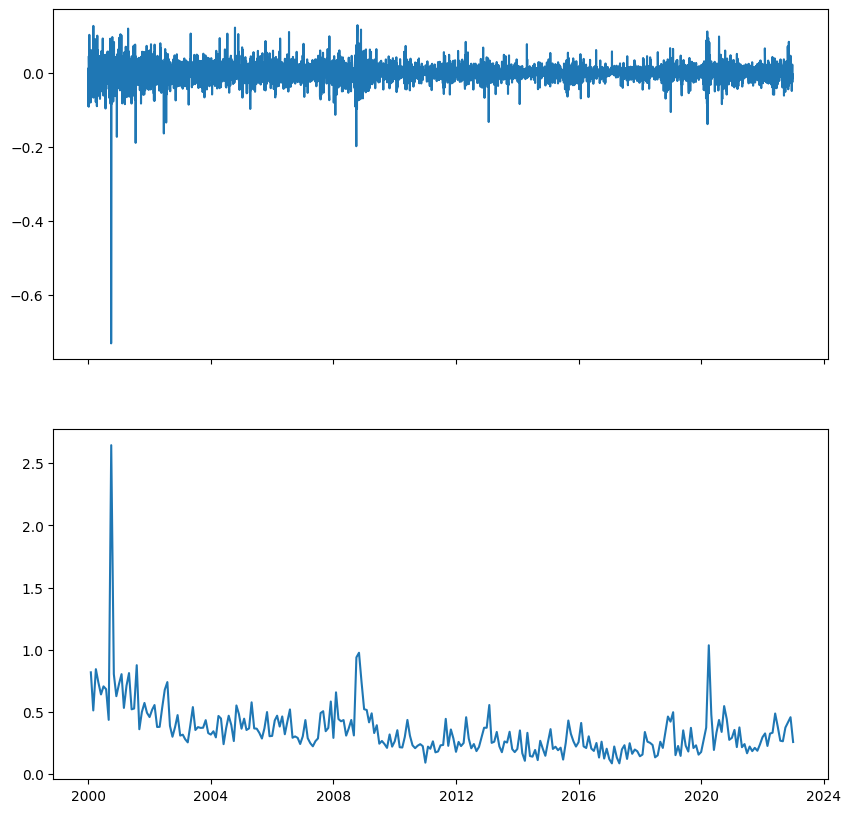

In [22]:
fig, ax = plt.subplots(2, 1, sharex=True,figsize=(10,10))
ax[0].plot(df)
ax[1].plot(df_rv)

# plt.tight_layout()
plt.show()

## Visualizing time series data

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Getting ready

In [24]:
# download data as pandas DataFrame
df = yf.download('MSFT', auto_adjust = False, progress=False)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

# create simple and log returns
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))

# dropping NA's in the first row
df.dropna(how = 'any', inplace = True)

### How to do it...

#### the `plot` method of pandas

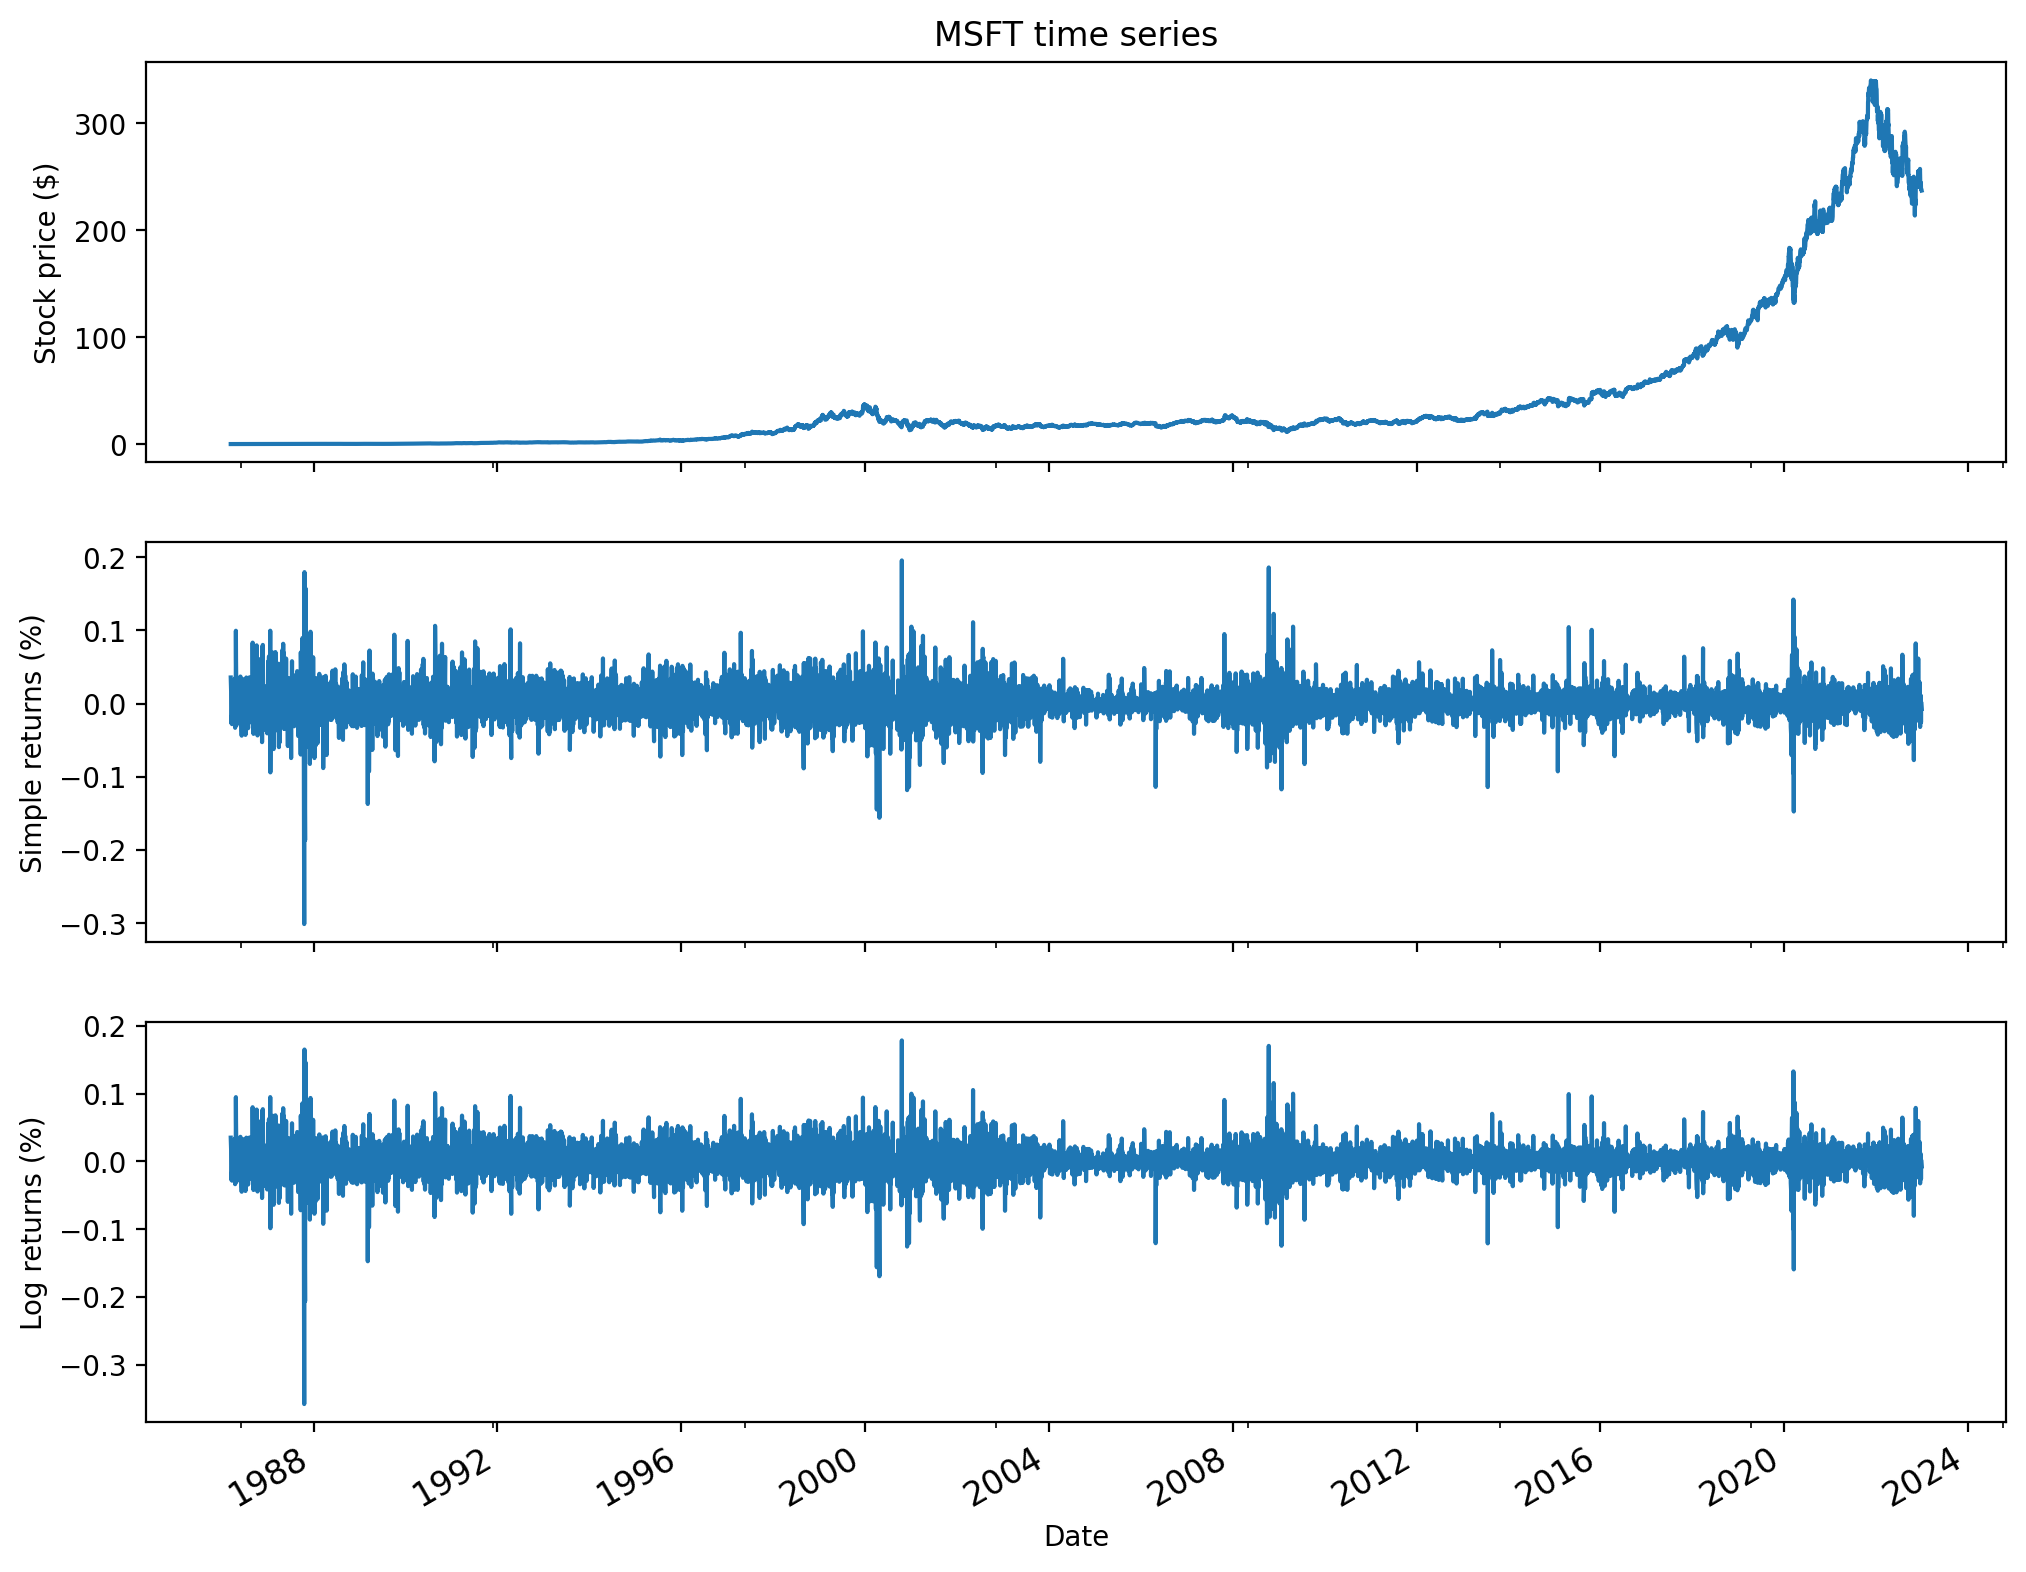

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# add prices
df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'MSFT time series',
         ylabel = 'Stock price ($)')

# add simple returns 
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

# add log returns 
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', 
         ylabel = 'Log returns (%)')

ax[2].tick_params(axis='x',
                 which='major',
                 labelsize=12)

# plt.tight_layout()
plt.show()

#### `plotly` + `cufflinks`

1. Import the libraries and handle the settings:

In [26]:
#  pip install cufflinks

In [27]:
# set up settings (run it once)
# cf.set_config_file(world_readable=True, theme='pearl',  offline=True)

# initialize notebook display
init_notebook_mode()

2. Create the plots:

In [28]:
cf.set_config_file(world_readable=True, theme='pearl',offline=True)
df.iplot(subplots=True, shape=(3,1), shared_xaxes=True, title='MSFT time series')

## Identifying outliers

0: Repeat the steps from recipe *Converting prices to returns*:

In [29]:
df = yf.download('AAPL', 
                start='2000-01-01', 
                end='2022-12-27',
                progress=False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [30]:
df['simple_rtn'] = df.adj_close.pct_change()

In [31]:
df.head()

adj_close  simple_rtn
Date                             
2000-01-03   0.851942         NaN
2000-01-04   0.780115   -0.084310
2000-01-05   0.791530    0.014633
2000-01-06   0.723033   -0.086538
2000-01-07   0.757282    0.047369

1. Calculate the rolling mean and standard deviation:

In [32]:
df_rolling = df[['simple_rtn']].rolling(window=21) \
                               .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

2. Join the rolling metrics to the original data:

In [33]:
df_outliers = df.join(df_rolling)

3. Define a function for detecting outliers:

In [34]:
def indentify_outliers(row, n_sigmas=3):
        '''
        Function for identifying the outliers using the 3 sigma rule. 
        The row must contain the following columns/indices: simple_rtn, mean, std.
        
        Parameters
        ----------
        row : pd.Series
        A row of a pd.DataFrame, over which the function can be applied.
        n_sigmas : int
        The number of standard deviations above/below the mean - used for detecting outliers
        
        Returns
        -------
        0/1 : int
        An integer with 1 indicating an outlier and 0 otherwise.
        '''''
        x = row['simple_rtn']
        mu = row['mean']
        sigma = row['std']
        
        if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
            return 1
        else:
            return 0 

4. Identify the outliers and extract their values for later use:

In [35]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, axis=1)

outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]

5. Plot the results: 

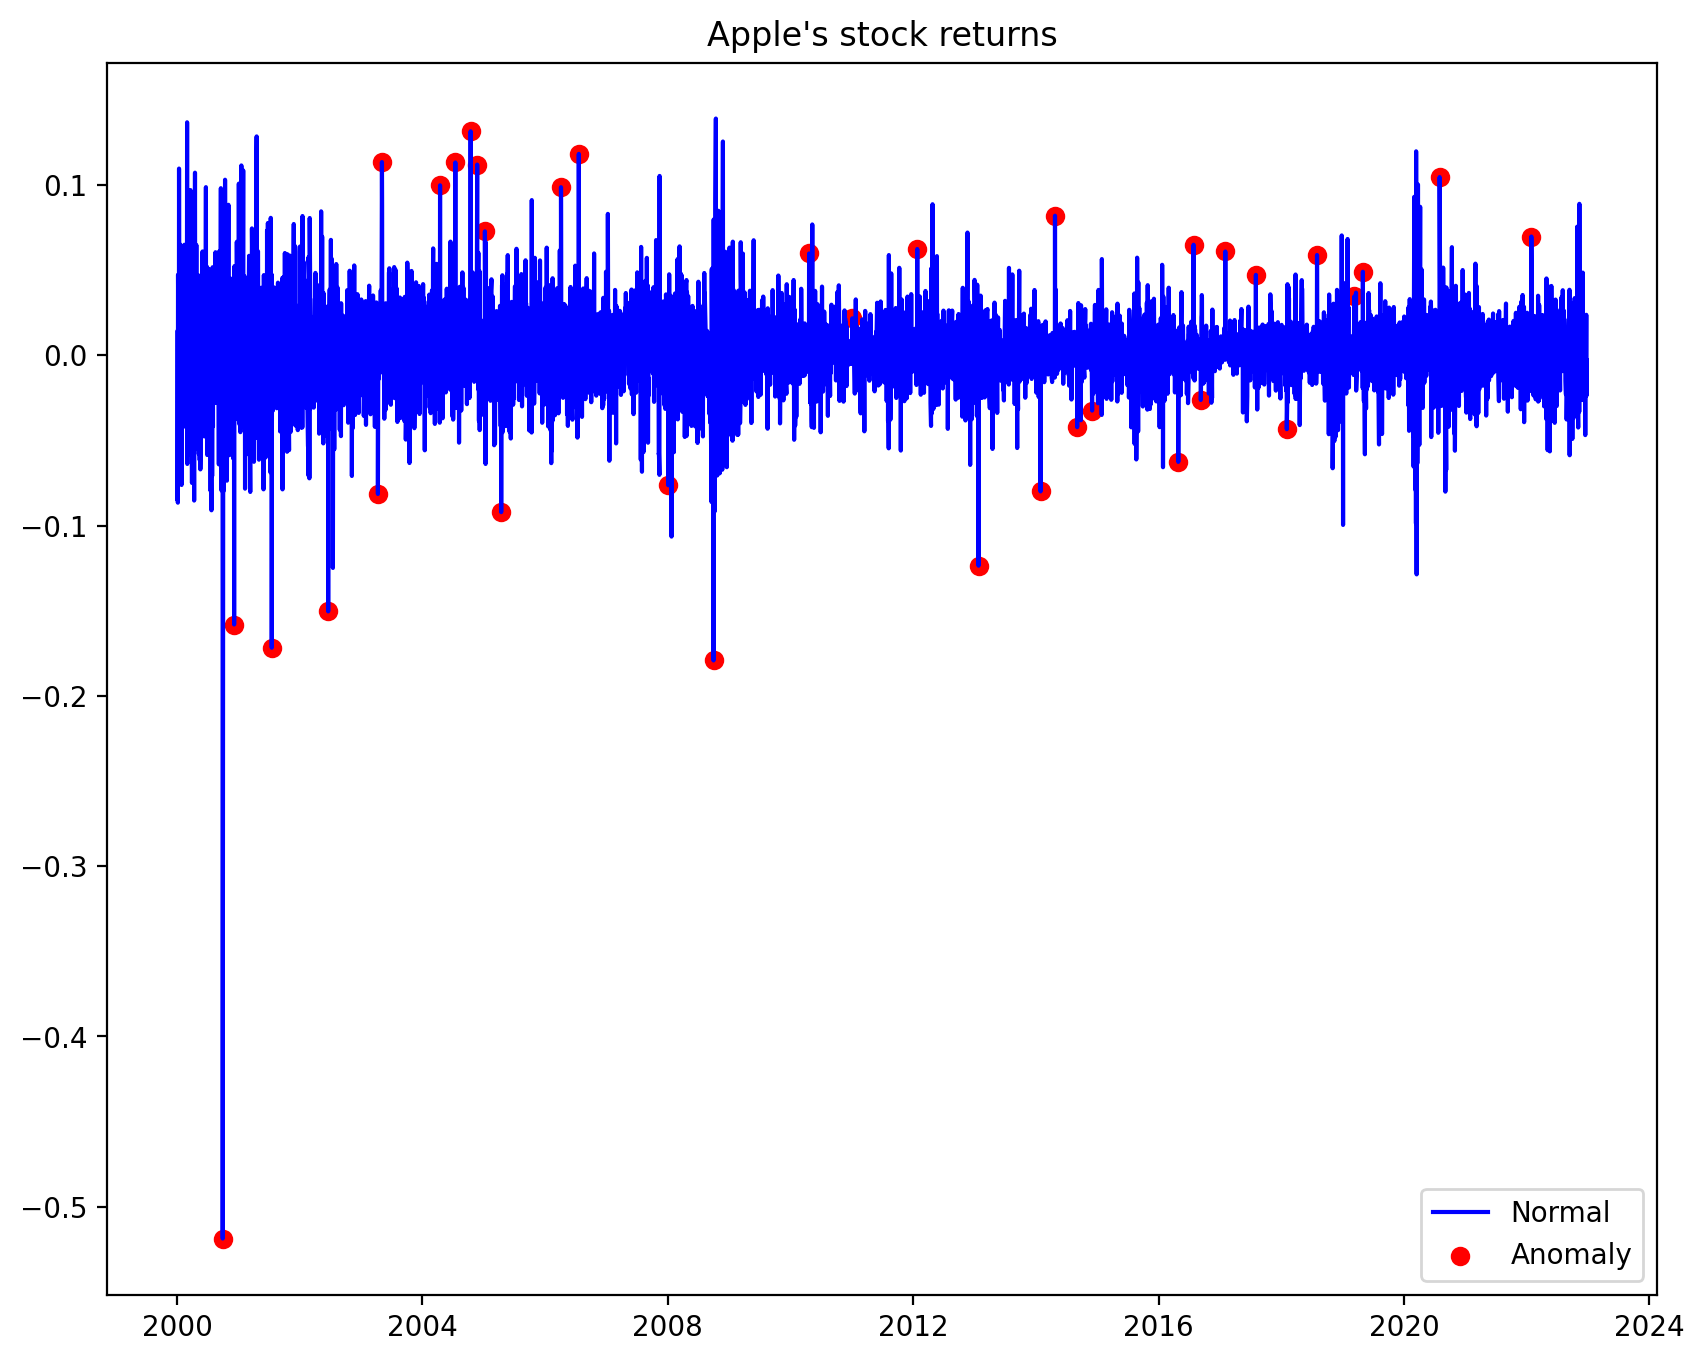

In [36]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
       color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
          color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')

# plt.tight_layout()
plt.show()

## Investigating stylized facts of asset returns

1. Import the libraries:

2. Download the S&P 500 data and calculate the returns:

In [37]:
df = yf.download('^GSPC', 
                start='1985-01-01', 
                end='2022-12-27',
                progress=False)

df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how = 'any')

#### Fact 1 - Non-Gaussian distribution of returns

1. Calculate the Normal PDF using the mean and standard deviation of the observed returns:

In [38]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

2. Plot the histogram and the Q-Q Plot:

/tmp/ipykernel_15218/924919768.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




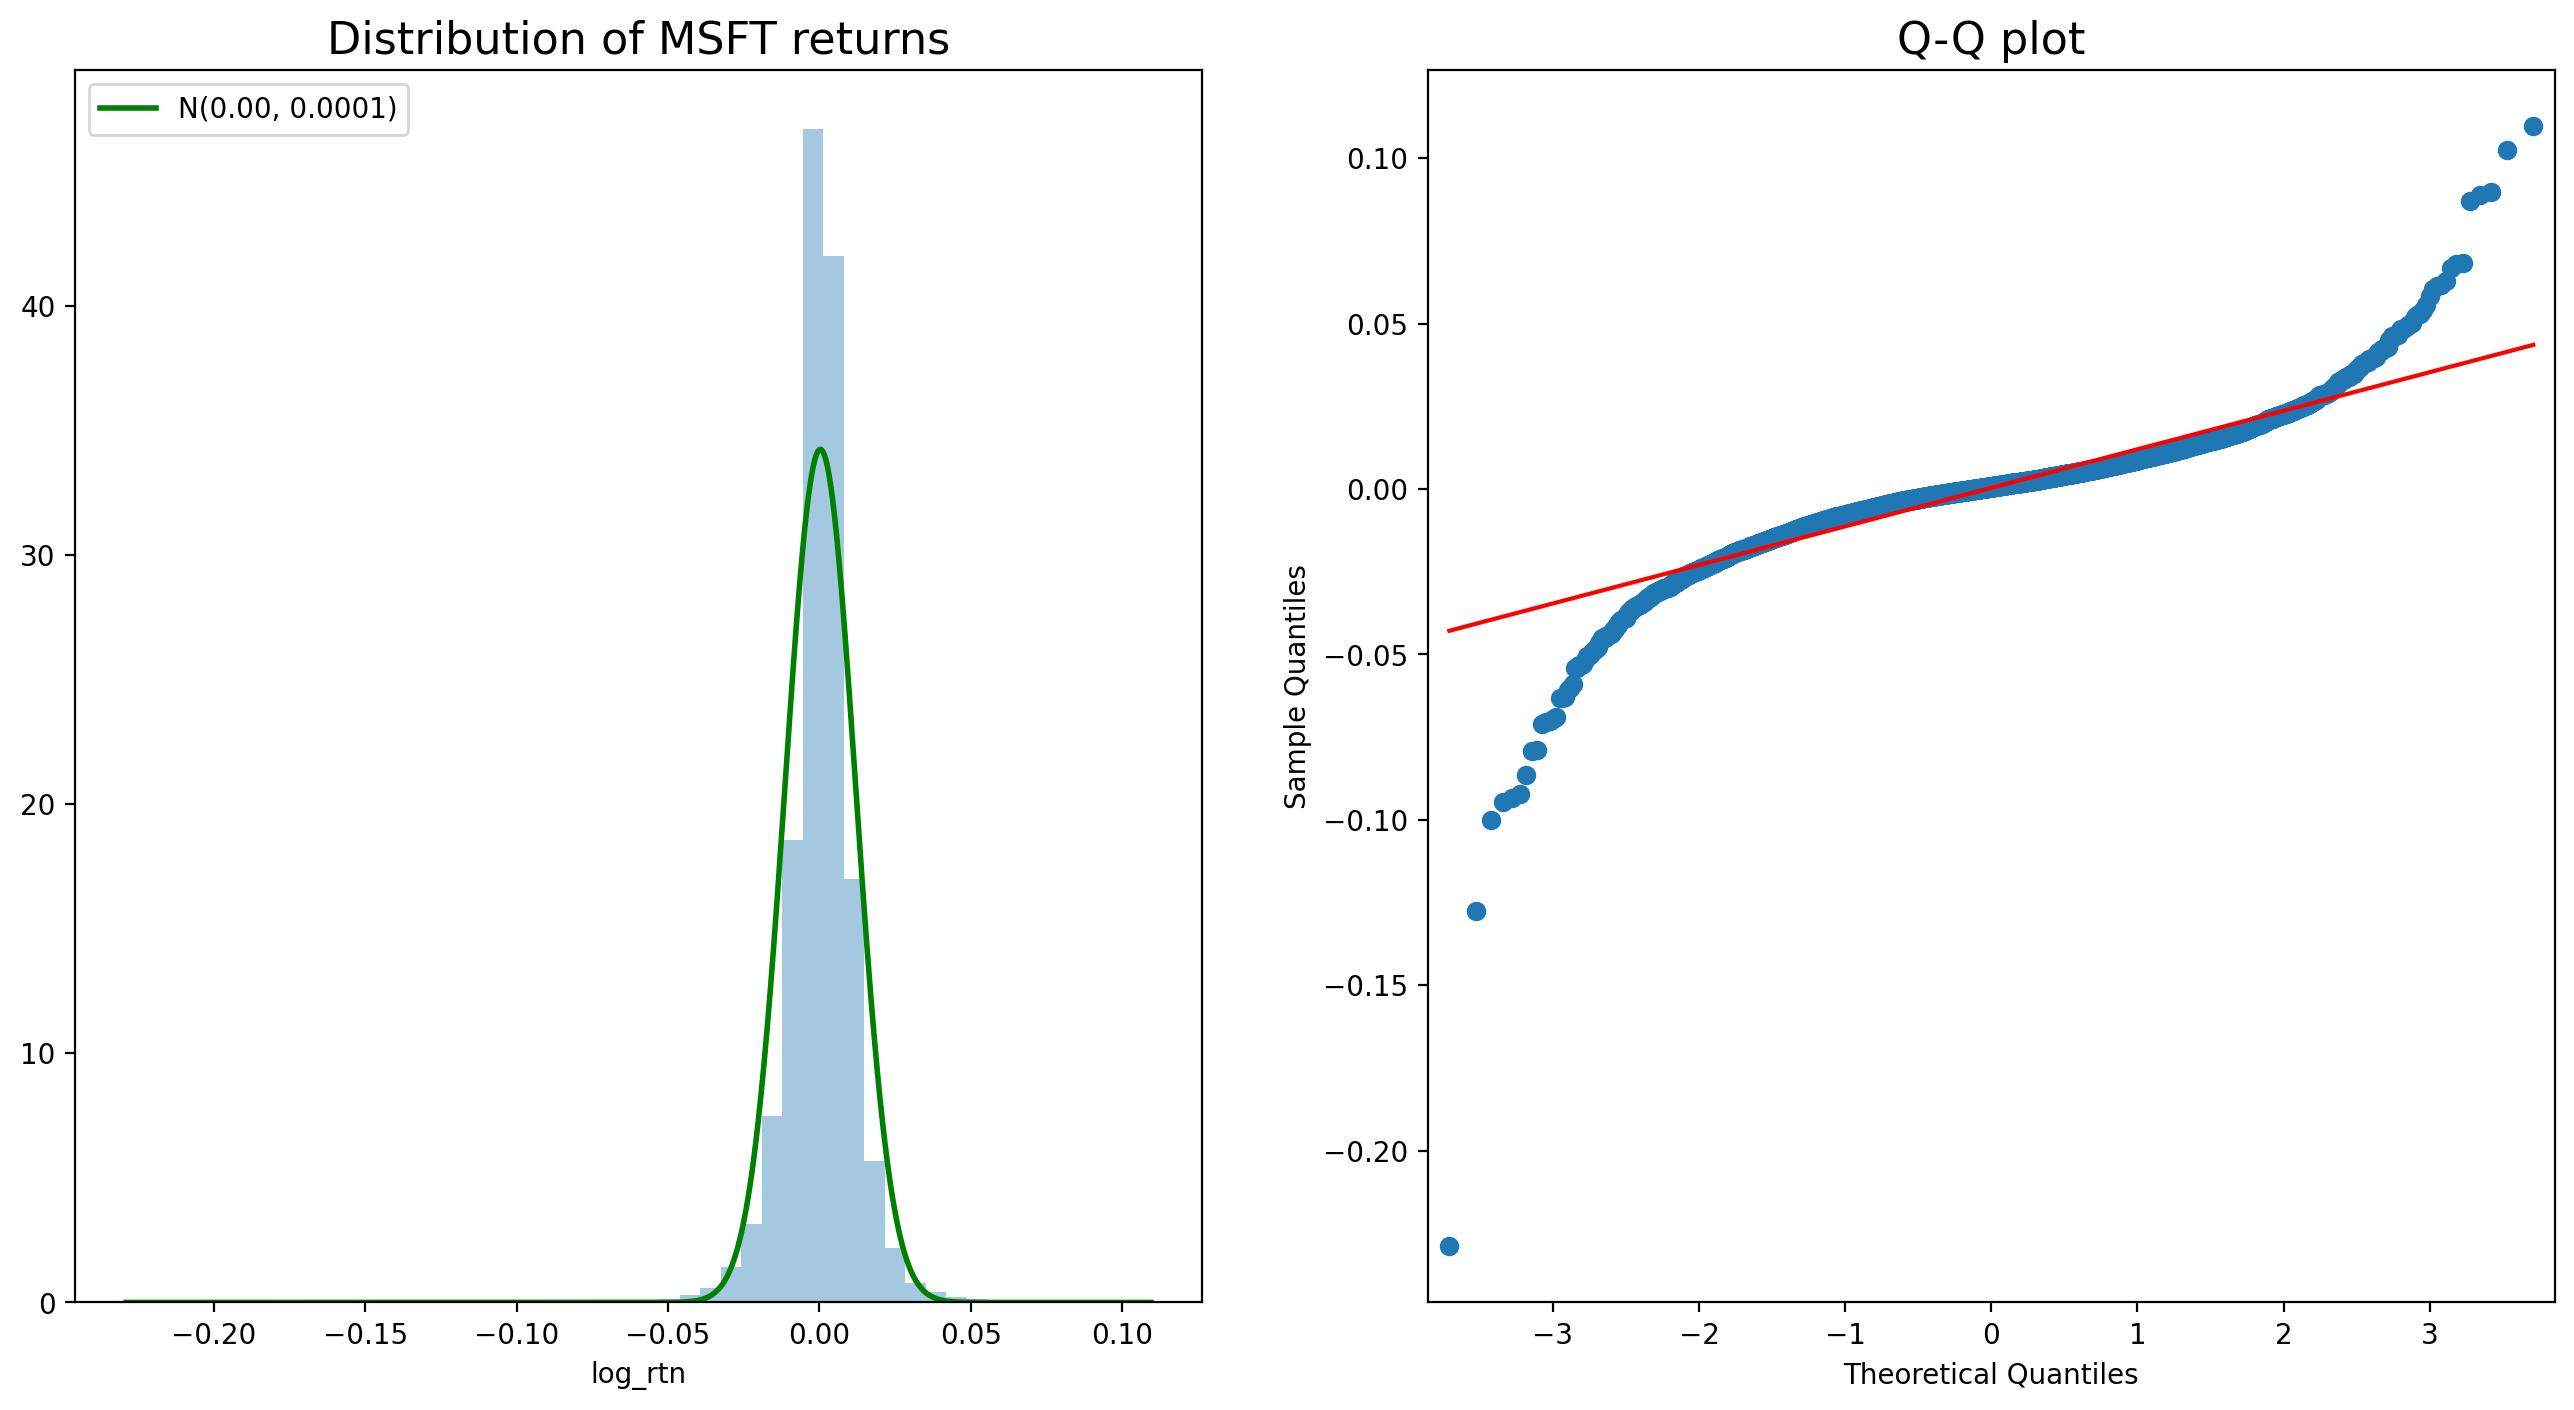

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])                                    
ax[0].set_title('Distribution of MSFT returns', fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, 'g', lw=2,
        label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

# plt.tight_layout()
plt.show()

3. Print the summary statistics of the log returns:

In [40]:
jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 1985-01-03 - 2022-12-23
Number of observations: 9573
Mean: 0.0003
Median: 0.0006
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0117
Skewness: -1.1882
Kurtosis: 25.3424
Jarque-Bera statistic: 258143.30 with p-value: 0.00


#### Fact 2 - Volatility Clustering

1. Run the following code to visualize the log returns series:

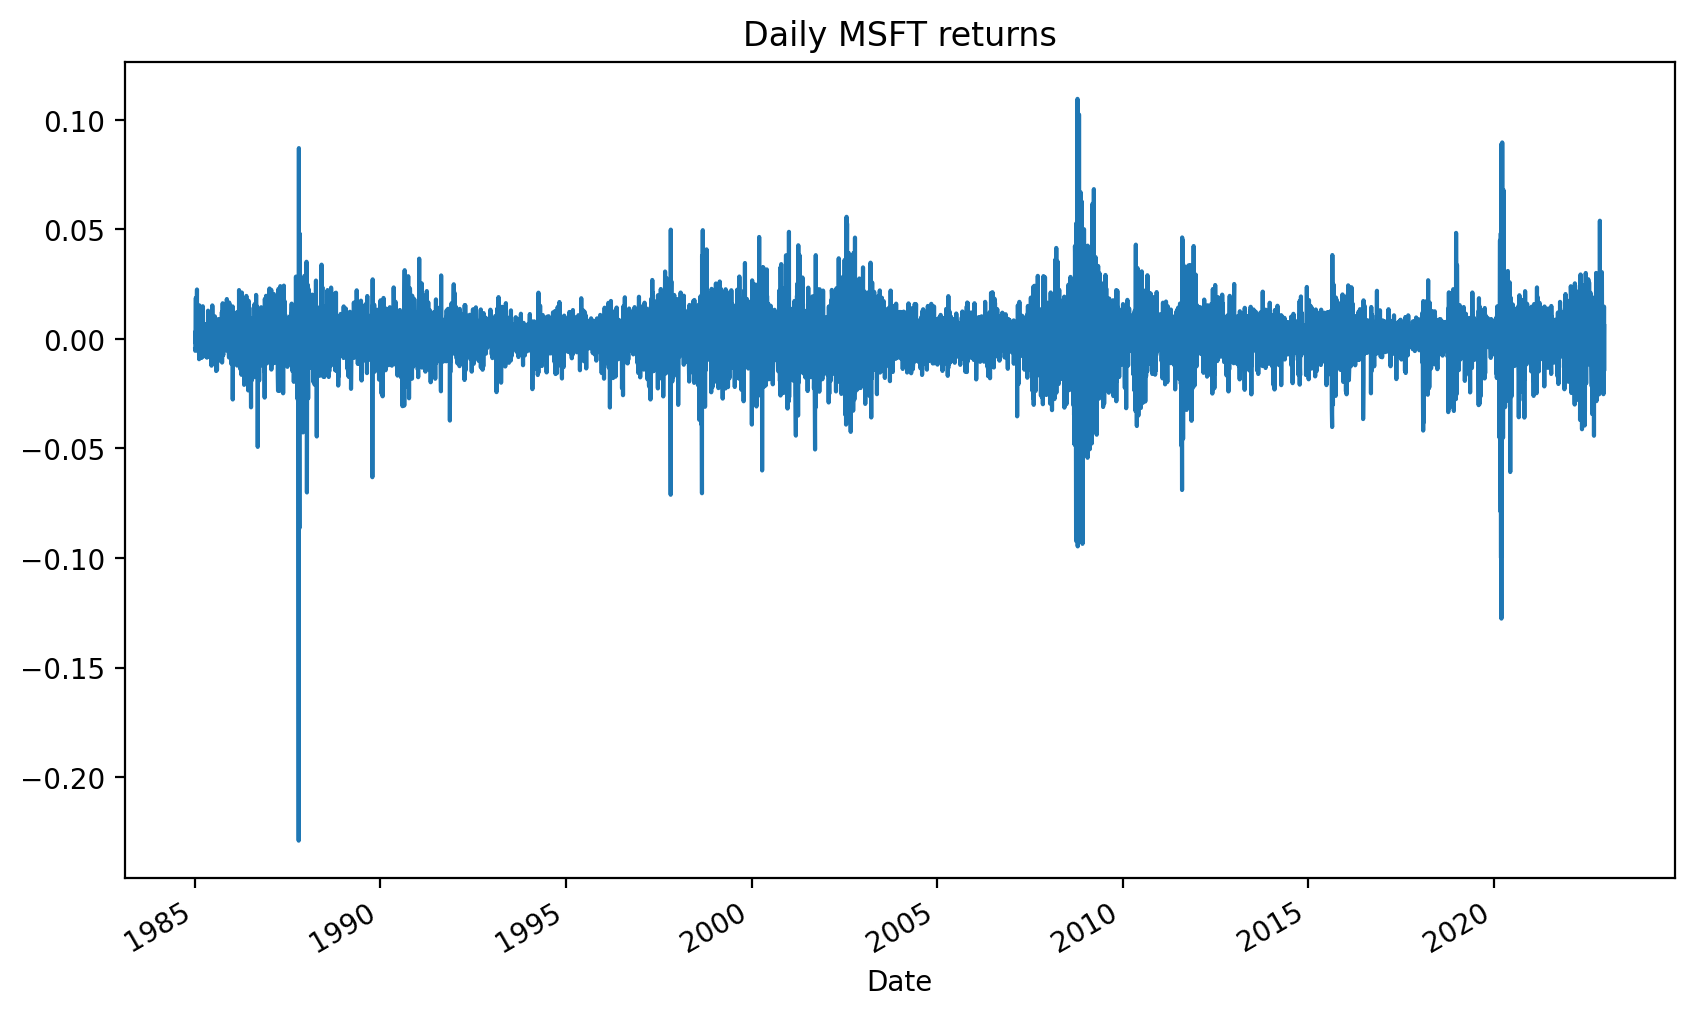

In [41]:
df.log_rtn.plot(title='Daily MSFT returns', figsize=(10, 6))

# plt.tight_layout()
plt.show()

#### Fact 3 - Absence of autocorrelation in returns

1. Define the parameters for creating the Autocorrelation plots:

In [42]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2. Run the following code to create ACF plot of log returns:

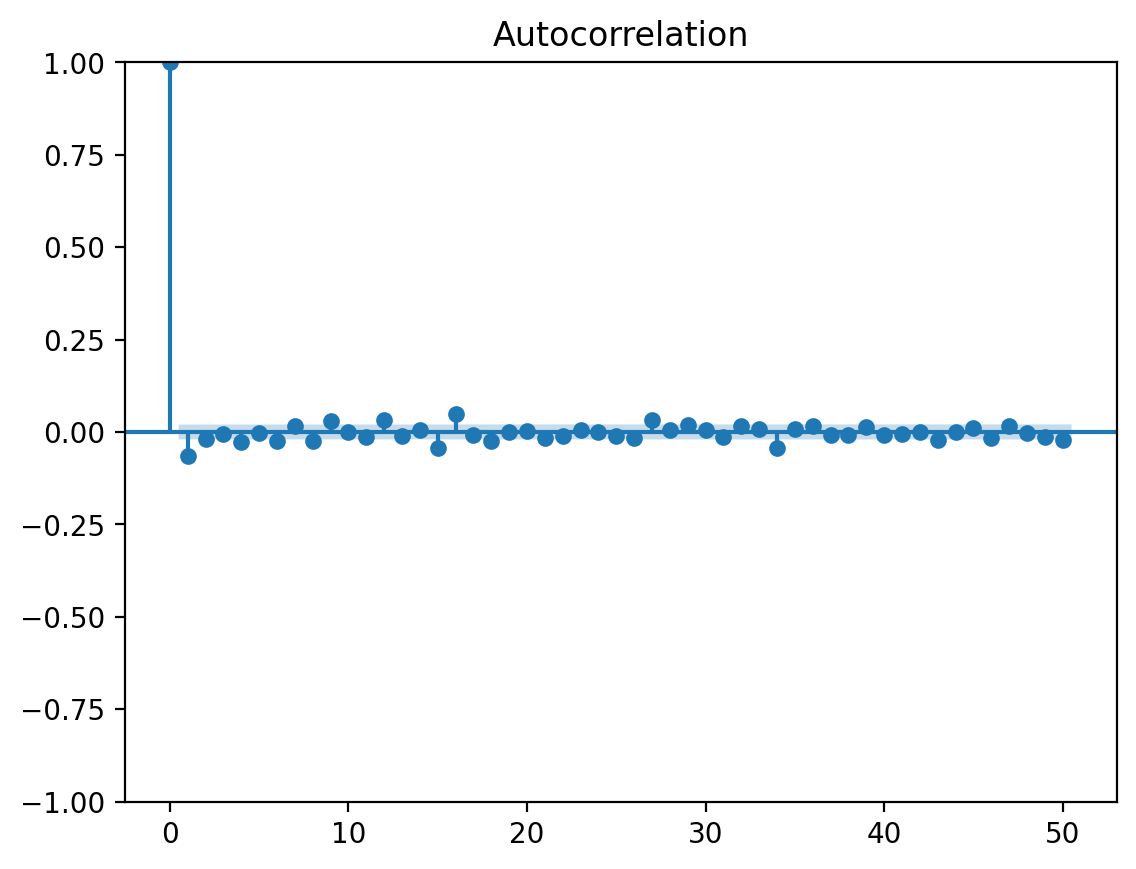

In [43]:
acf = smt.graphics.plot_acf(df.log_rtn, 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

#plt.tight_layout()
plt.show()

#### Fact 4 - Small and decreasing autocorrelation in squared/absolute returns

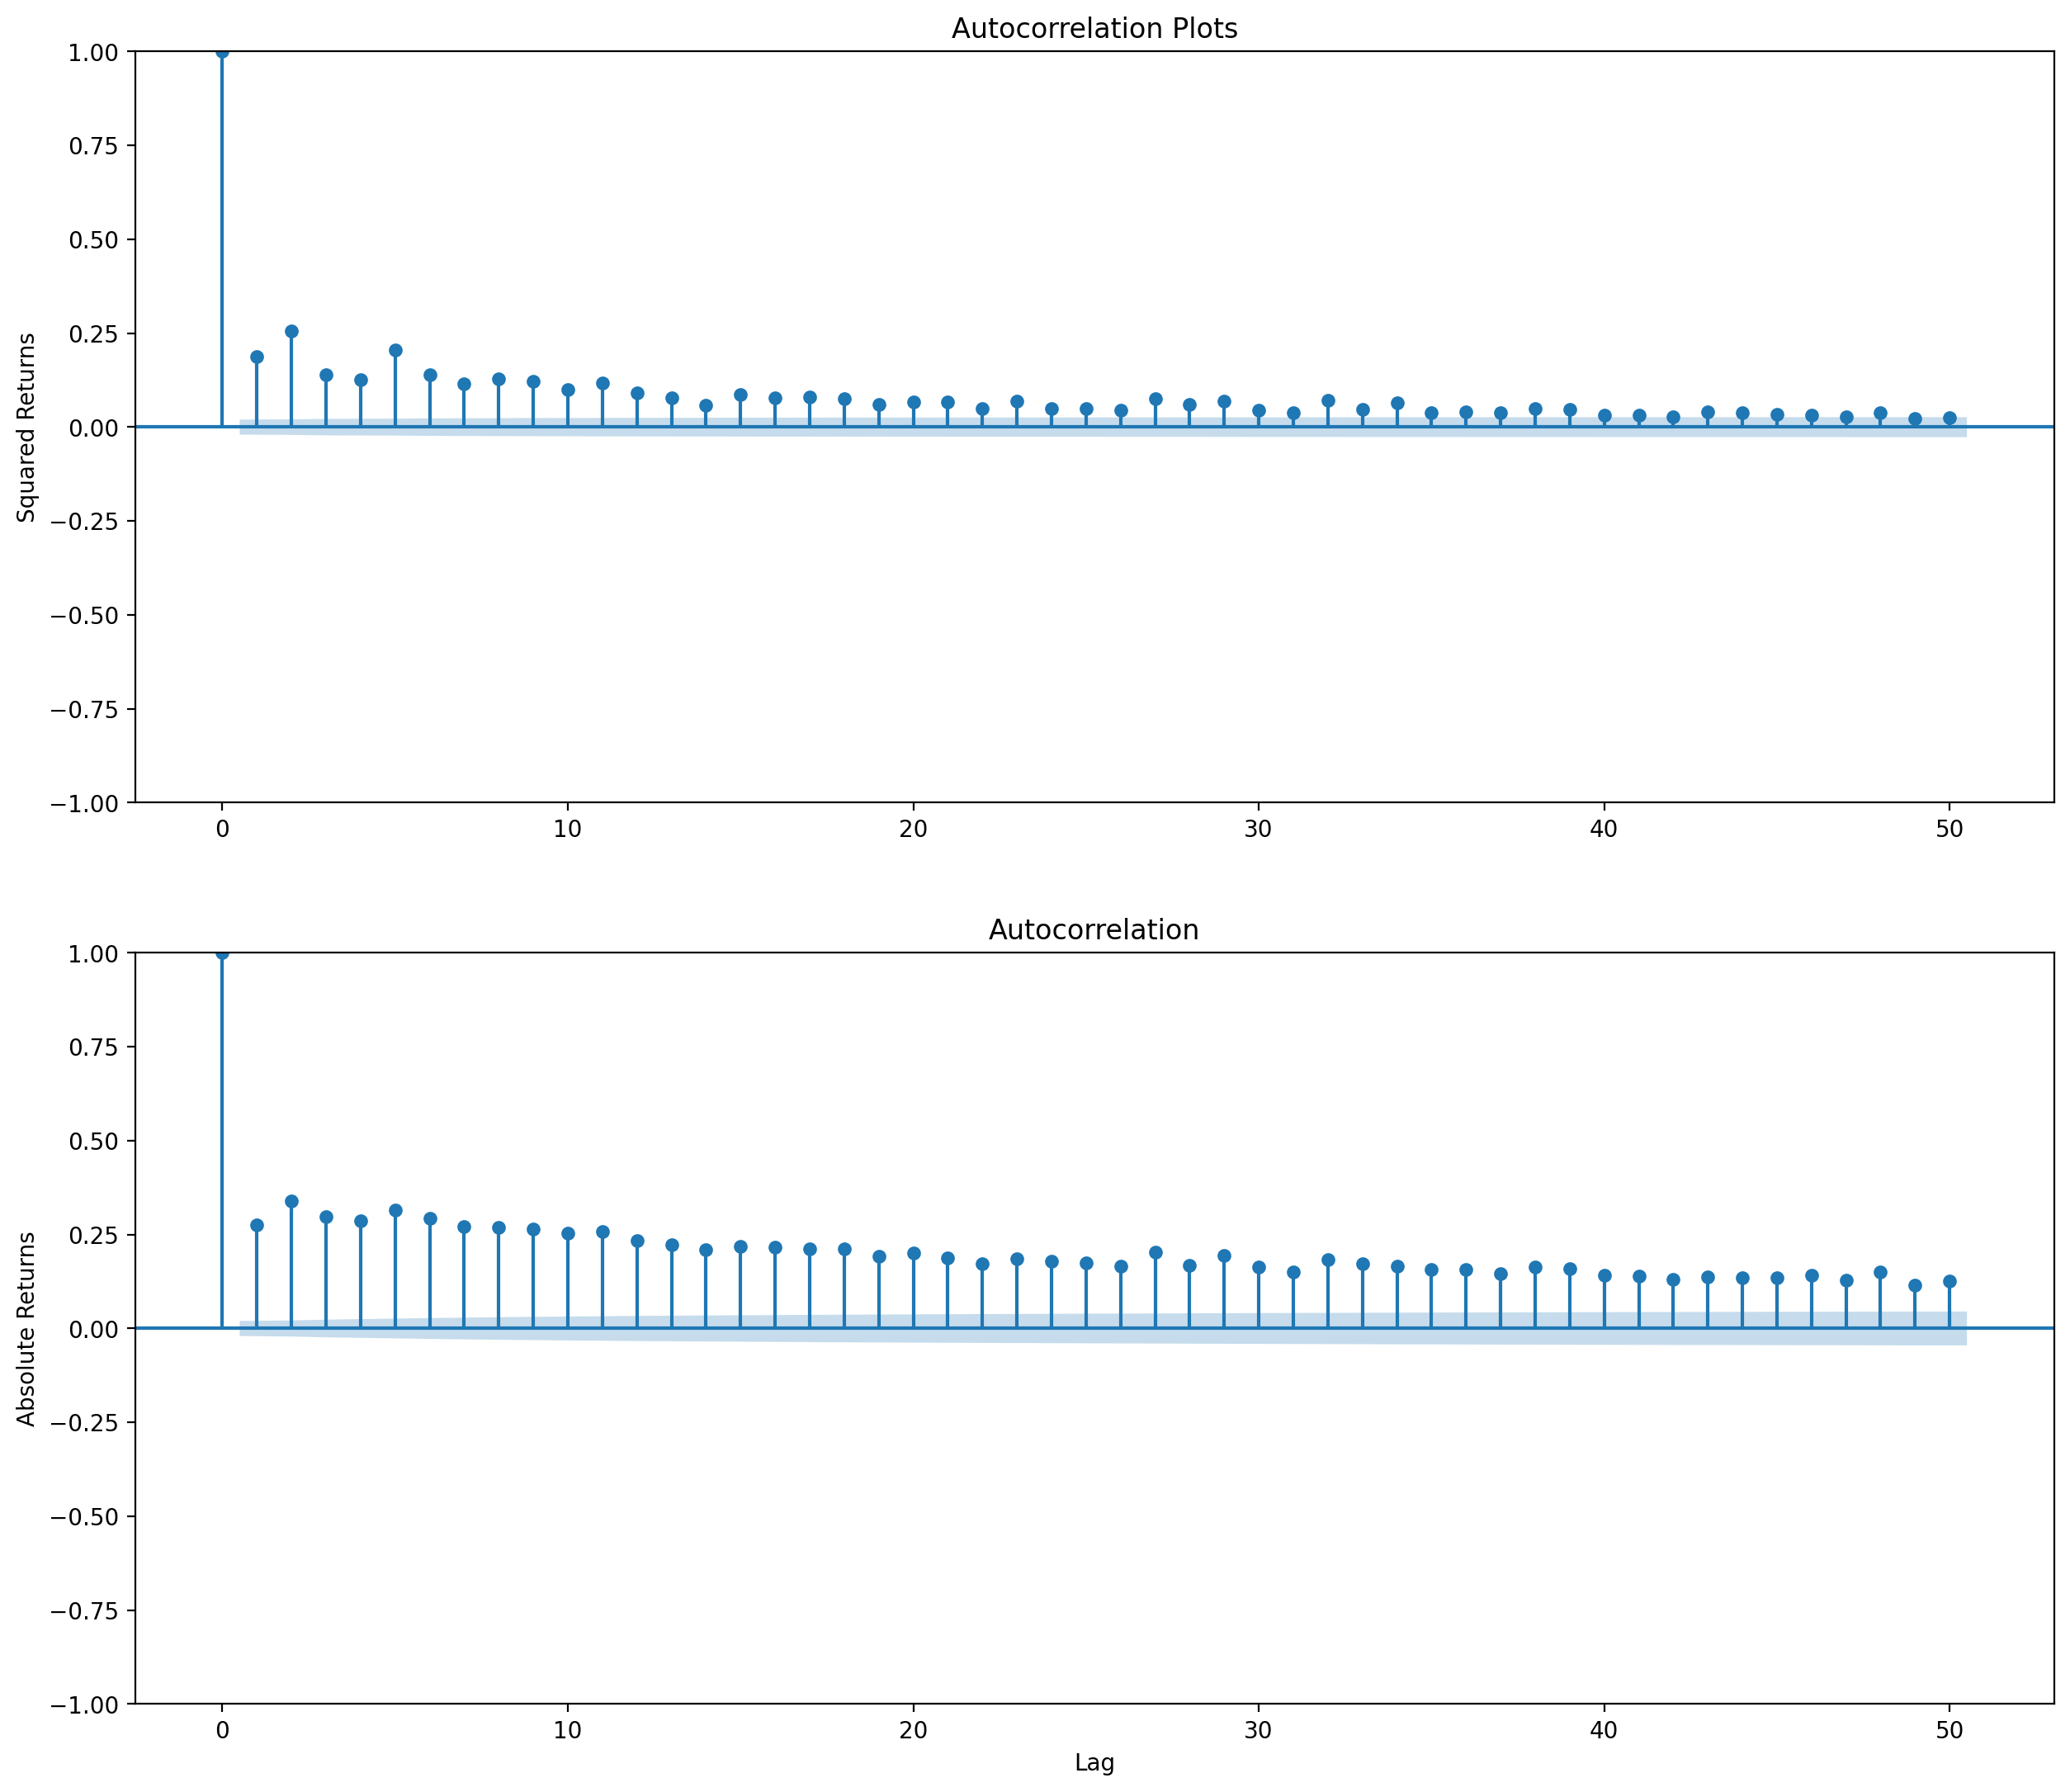

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(15, 13))

smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS, 
                     alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots',
         ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, 
                     alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
         xlabel='Lag')

# plt.tight_layout()
plt.show()

In [45]:
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()